### **Notes**
1. This notebook was entirely built and tested using Google Colab

2. Data : \

    a. Part 1 (Plant Species' Classification) - The dataset has been downloaded to my Google Drive account in the directory */content/drive/MyDrive/Colab Notebooks/Assignments/CNN/* under the name *psdata.zip*. The drive is mounted for accessing the directories. The user of this notebook needs to store psdata.zip in an appropriate directory and change the path in this notebook to load it

    b. Part 3 (Automobile Dataset Preparation) - This dataset has been *created from scratch* and archived into a cars.zip file, which is submitted as part of the assignment. The user needs to place cars.zip in an appropriate directory and change the path in this notebook to load it

    c. Part 4 (Flowers Data Set) - Data set is downloaded to */content/* directory, which is accessed by the notebook. The loaded data set is deleted after the session terminates 

3. Running this notebook requires manual intervention at two points \
    a. Part 1 - Mounting the Google drive from where the Plant Seedling dataset is loaded
    b. Part 3 - Mounting the Google drive from where the Automobile dataset is loaded
    b. Part 5 - Uploading an image from the local system to make a Flower classification prediction  

4. There are 2 Fully Connected Networks and 3 Convolutional NNs that are trained in this notebook. The end to end execution time is about 90 minutes

Import all required libraries used across this assignment

In [ ]:
# Ignore warning messages
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('tensorflow').disabled = True

# Essential python libraries for data processing 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__
from sklearn.model_selection import train_test_split

# Google drive access libraries
from google.colab import drive, files

# OpenCV for Image processing, OS for directory handling
import cv2,os

# Libararies for supervised machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# Keras libraries for image data preprocessing, model building and training  
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD,Adagrad
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input

# Imagenet pre-trained models
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image

# Image display utility
from IPython.display import HTML, display


### **Part 1 - Plants' Species Classification**

Mount Google Drive and load the data set into a specific directory

In [ ]:
\drive.mount('/content/drive',force_remount=True)
images_path = "/content/drive/MyDrive/Colab Notebooks/Assignments/CNN/psdata.zip"

from zipfile import ZipFile
with ZipFile(images_path, 'r') as zip:
  zip.extractall()

Mounted at /content/drive


Let's look at the different plant species classes

In [ ]:
plant_classes=os.listdir('/content/train/')
plant_classes.sort()
plant_classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

There are 12 classes of plant species, under which all training set images are grouped

Let us read the training set images from the file system and store them in numpy Arrays

In [ ]:
def readTrainData(trainDir):
    data = []
    labels = []
    # loop over the input images
    dirs = os.listdir(trainDir) 
    for dir in dirs:
        absDirPath = os.path.join(os.path.sep,trainDir, dir)
        images = os.listdir(absDirPath)
        for imageFileName in images:
            # load the image, pre-process it, and store it in the data list
            imageFullPath = os.path.join(trainDir, dir, imageFileName)
            #print(imageFullPath)
            img = load_img(imageFullPath)
            arr = img_to_array(img)  # Numpy array with shape (233,233,3)
            arr = cv2.resize(arr, (64,64)) #Numpy array with shape (HEIGHT, WIDTH,3)
            #print(arr.shape) 
            data.append(arr)
            label = plant_classes.index(dir)
            labels.append(label)

    return data, labels

Let us read the training data set into numpy arrays and normalize the values for independent features X

In [ ]:
X, Y = readTrainData("/content/train/")
X = np.array(X, dtype="float") / 255.0
Y = np.array(Y)

Let us visualize one image from each class and their corresponding class number and name. We need this to understand which Plant species class is mapped to which number between [0..11]. This information is useful to visualize all plant species as well as a visual aid to confirm the correctness of our prediction

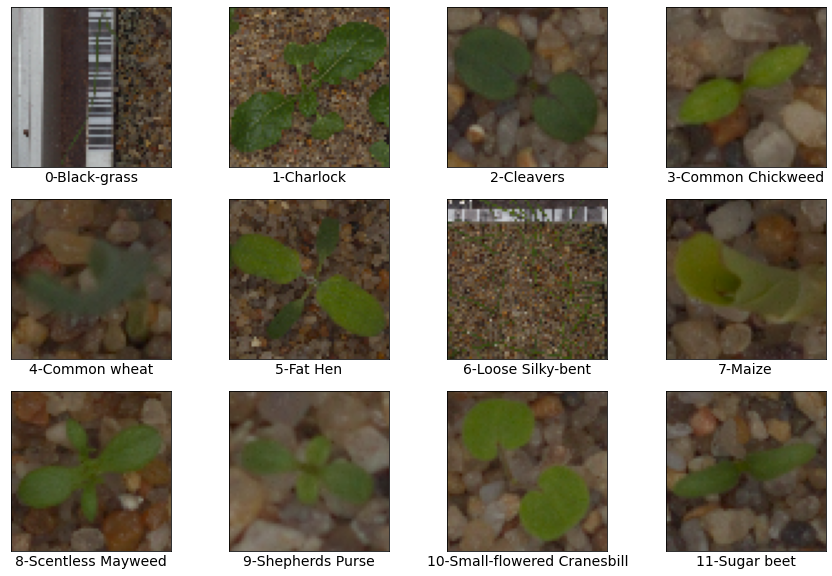

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

fig=plt.figure(figsize=(15,10))
j=0
for i in set(Y):
  result = np.where(Y == i)
  plt.subplot(3, 4, j+1)
  plt.imshow(X[result[0][0]], cmap=plt.cm.binary)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(str(i)+"-"+plant_classes[i],fontsize=14)
  j+=1
plt.show()

Number : The training set consists of 4767 images belonging to 12 classes \
Shapes : Different images are of different shapes \
Channels: All images are RGB with 3 channels

Let us visualize some random images across all plant species classes from the training set 

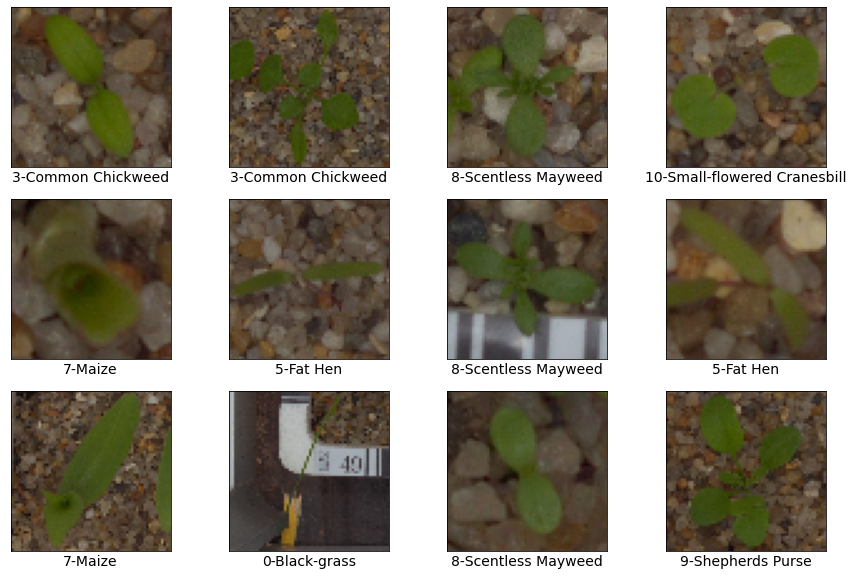

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

fig=plt.figure(figsize=(15,10))

randarr=[]
for i in range(12):
    rand = np.random.randint(0,X.shape[0])
    plt.subplot(3, 4, i+1)
    plt.imshow(X[rand])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(str(Y[rand])+"-"+plant_classes[Y[rand]],fontsize=14)
plt.show()

As the first step, we will use two supervised learning classifier algorithms to train the dataset and observe performance \
1. RandomForest classifier \
2. DecisionTree classifier \

Split the data set into train and validation sets. 

Run the RandomForest and Decision Tree Classifiers.

Observe the model performance

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.15, random_state=42)

# We flatten the 64x64 pixels (Image dimenssions) in 3 channels (RGB) , thus creating 12288 features for training 

X_train_RS = np.reshape(X_train,(len(X_train),64*64*3))
X_val_RS = np.reshape(X_val,(len(X_val),64*64*3))

# Use a RandomForest classifier to train and make predictions on the validation set
ml_model = RandomForestClassifier(n_estimators = 50, max_depth=5, random_state=42)

#Use a DecisionTree classifier
#ml_model = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, random_state=42)

ml_model.fit(X_train_RS, y_train)
y_predict = ml_model.predict(X_val_RS)

print("Train Accuracy:",round(ml_model.score(X_train_RS, y_train)*100),"%")
res = round(ml_model.score(X_val_RS, y_val)*100)
print("Validation Accuracy :",res,"%")

Train Accuracy: 50 %
Validation Accuracy : 39 %


As seen in the confusion matrix displayed below, there are several wrong predictions because of the low accuracy levels of the model

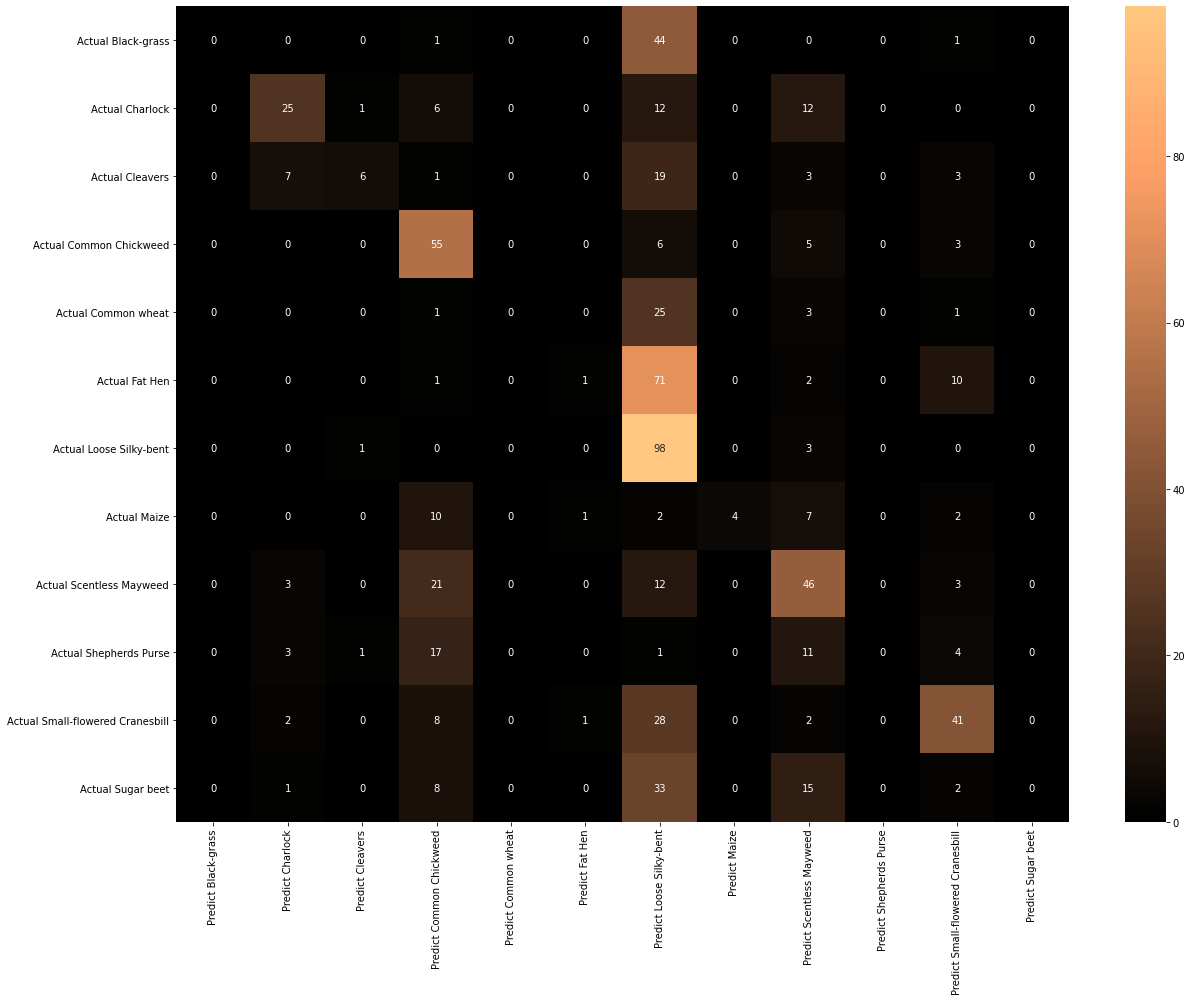

In [ ]:
cm=metrics.confusion_matrix(y_val,y_predict)

df_cm = pd.DataFrame(cm, index = ["Actual "+i for i in plant_classes],
                  columns = [i for i in ["Predict "+pc for pc in plant_classes]])
plt.figure(figsize = (20,15))
sns.heatmap(df_cm, annot=True,cmap='copper')

1. RandomForest classifier provides Train and validation accuracy in the 40% range without much overfitting

2. DecisionTrees classifier provides train and validation accuracy in the 35% range without much overfitting

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

table = pd.DataFrame({'Learning Method':['Machine Learning'], 'Validation Accuracy (%)': [res]},index={'1'})
table = table[['Learning Method', 'Validation Accuracy (%)']]
table

Learning Method  Validation Accuracy (%)
1  Machine Learning                       39

Next, we will try training the data using Neural networks with fully connected layers. Initialize the hyperparameters

Notes \
1. In this assignment, I have consistently used Adagrad optimizer, which provided the best performance among [Adagrad, SGD, Adam] all the time (probably because the data set is relatively sparse). I did experiment with different optimizers, learning rates, batch sizes and epochs. The initialized hyperparameters are the ones that provided the optimal performance.

2. ReLU is uses as the activation function consistently across all the training episodes

3. I have deliberately not used early stopping, although I experimented with it. The reason is, I wanted to plot the metrics graphically after each run, for which I needed to hold n_epochs constant. 

In [ ]:
batch_size=32
n_epochs=20

#opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None)
#opt = SGD(learning_rate=0.005,momentum=0.9,nesterov=True)
opt = Adagrad(learning_rate=0.005)

act_fn = 'relu'

Construct the Neural network using fully connected layers. We will include Batch Normalization to prevent overfitting. We use ReLU as the activation function

In [ ]:
# Initialising the Neural Networks classifier
nn_classifier = Sequential()

nn_classifier.add(Flatten())

nn_classifier.add(Dense(units = 4096,kernel_initializer='he_normal'))
nn_classifier.add(Activation(act_fn))
nn_classifier.add(BatchNormalization())

nn_classifier.add(Dense(units = 2048,kernel_initializer='he_normal'))
nn_classifier.add(Activation(act_fn))
nn_classifier.add(BatchNormalization())

nn_classifier.add(Dense(units = 1024,kernel_initializer='he_normal'))
nn_classifier.add(Activation(act_fn))
nn_classifier.add(BatchNormalization())

nn_classifier.add(Dense(units = 512,kernel_initializer='he_normal'))
nn_classifier.add(Activation(act_fn))
nn_classifier.add(BatchNormalization())

nn_classifier.add(Dense(units = 256,kernel_initializer='he_normal'))
nn_classifier.add(Activation(act_fn))
nn_classifier.add(BatchNormalization())

nn_classifier.add(Dense(units = 128,kernel_initializer='he_normal'))
nn_classifier.add(Activation(act_fn))
nn_classifier.add(BatchNormalization())

nn_classifier.add(Dense(units = 64,kernel_initializer='he_normal'))
nn_classifier.add(Activation(act_fn))
nn_classifier.add(BatchNormalization())

# The final output layer with 10 neurons to predict the categorical classifcation
nn_classifier.add(Dense(units = 12, activation = 'softmax'))

Firstly, We will create the training and validation data sets required to train neural networks. We use ImageDataGenerator to perform image data pre-processing such as random flipping, zooming, shearing etc. This is done to prevent overfitting of the data \

Next, we initialize the required callbacks such as \
1. Learning rate Annealing
2. Early Stopping based on validation loss (Not used as mentioned above)
3. Save Best Model - We will also save the best performing model in the process 

In [ ]:
# Create data generator for training data with data augmentation and normalizing all
# values by 255
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2,
                                   horizontal_flip = True,
                                   vertical_flip=True,
                                   validation_split=0.25)

# Carve out the training set
training_set = train_datagen.flow_from_directory('/content/train',
                                                 target_size = (64, 64),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 subset='training',
                                                 shuffle=True)
# Now, create the validation  set
val_set = train_datagen.flow_from_directory('/content/train',
                                            target_size = (64, 64),
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            subset='validation',
                                            shuffle=True)

# Learning Rate Annealing 
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# Early Stopping
stop_early = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Save the best model weights during traning
save_bestmodel = ModelCheckpoint('best_plantspecies_nn_model.h5'
                                ,monitor='val_accuracy'
                                ,save_best_only=True
                                ,save_weights_only=True)

Found 3581 images belonging to 12 classes.
Found 1186 images belonging to 12 classes.


Compile and train the neural network

In [ ]:
nn_classifier.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = nn_classifier.fit_generator(training_set,
                         epochs = n_epochs,
                         validation_data = val_set,
                         callbacks=[reduce_lr, 
                                    #stop_early, 
                                    save_bestmodel])

Epoch 1/20
112/112 [==============================] - 66s 565ms/step - loss: 2.8383 - accuracy: 0.1308 - val_loss: 2.8716 - val_accuracy: 0.0691
Epoch 2/20
112/112 [==============================] - 64s 571ms/step - loss: 2.2259 - accuracy: 0.2501 - val_loss: 2.2459 - val_accuracy: 0.2285
Epoch 3/20
112/112 [==============================] - 63s 567ms/step - loss: 2.1231 - accuracy: 0.2751 - val_loss: 1.9997 - val_accuracy: 0.3204
Epoch 4/20
112/112 [==============================] - 64s 570ms/step - loss: 1.9544 - accuracy: 0.3271 - val_loss: 1.9101 - val_accuracy: 0.3373
Epoch 5/20
112/112 [==============================] - 63s 567ms/step - loss: 1.9062 - accuracy: 0.3415 - val_loss: 1.8745 - val_accuracy: 0.3373
Epoch 6/20
112/112 [==============================] - 63s 567ms/step - loss: 1.8231 - accuracy: 0.3730 - val_loss: 1.8208 - val_accuracy: 0.3777
Epoch 7/20
112/112 [==============================] - 63s 565ms/step - loss: 1.8188 - accuracy: 0.3555 - val_loss: 1.7307 - val_ac

Plot the accuracy and loss for this model

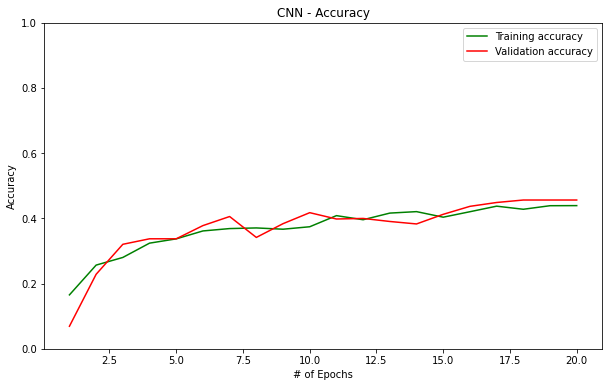

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

keys = sorted(history.history.keys())

acc_train = history.history[keys[0]]
acc_val = history.history[keys[3]]
epochs = range(1,n_epochs+1)
plt.subplots(figsize=(10,6))
plt.ylim(0,1)
plt.plot(epochs, acc_train, 'green', label='Training accuracy')
plt.plot(epochs, acc_val, 'red', label='Validation accuracy')
plt.title('CNN - Accuracy')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

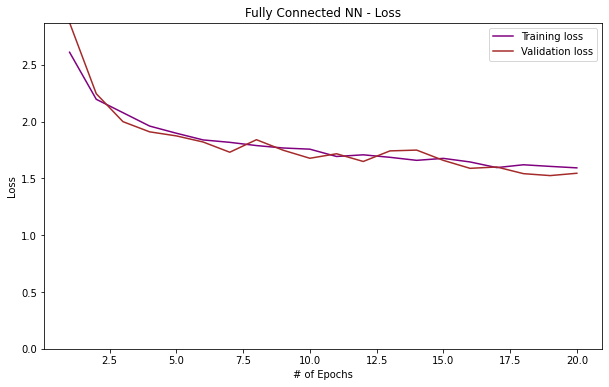

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

loss_train = history.history["loss"]
loss_val = history.history["val_loss"]
epochs = range(1,n_epochs+1)
plt.subplots(figsize=(10,6))
plt.ylim(0,np.max([loss_train,loss_val]))
plt.plot(epochs, loss_train, 'purple', label='Training loss')
plt.plot(epochs, loss_val, 'brown', label='Validation loss')
plt.title('Fully Connected NN - Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

res=np.max(acc_val)
tmp = pd.DataFrame({'Learning Method':['Fully Connected NN'], 'Validation Accuracy (%)': [round(100*res,2)]},index={'2'})
table= pd.concat([table, tmp])
table = table[['Learning Method', 'Validation Accuracy (%)']]
table

Learning Method  Validation Accuracy (%)
1    Machine Learning                    39.00
2  Fully Connected NN                    45.62

Fully connected neural network without any convolutional layers provides an accuracy of ~45% for both training and validation data sets. This is a marginal improvement compared to supervised machine learning model. There is no overfitting seen at this level of accuracy

As the next step, We will use a model built on Convolutional Layers + Fully 
Connected Layers to train the data set

Let us drop some weights to prevent overfitting. Epoch number fixed after multiple trial and error

In [ ]:
dropout_ratio = 0.5
n_epochs = 25

2D Convolution Layers with Max Pooling, Batch Normalization and Weight dropout layers

Finally Fully connected layers with softmax activation

In [ ]:
# Initialising the CNN classifier
cnn_classifier = Sequential()

# Add a Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
cnn_classifier.add(Conv2D(64, (3, 3), input_shape = (64, 64, 3), padding='same'))
cnn_classifier.add(BatchNormalization())
cnn_classifier.add(Activation(act_fn))

cnn_classifier.add(Conv2D(128, (3, 3), input_shape = (64, 64, 3), padding='valid'))
cnn_classifier.add(BatchNormalization())
cnn_classifier.add(Activation(act_fn))
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))
cnn_classifier.add(Dropout(dropout_ratio))

cnn_classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), padding='valid'))
cnn_classifier.add(BatchNormalization())
cnn_classifier.add(Activation(act_fn))

cnn_classifier.add(Flatten())

cnn_classifier.add(Dense(units = 512))
cnn_classifier.add(Activation(act_fn))
cnn_classifier.add(BatchNormalization())
cnn_classifier.add(Dropout(dropout_ratio))

cnn_classifier.add(Dense(units = 128))
cnn_classifier.add(Activation(act_fn))
cnn_classifier.add(BatchNormalization())

# The final output layer with 12 neurons to predict the categorical classifcation
cnn_classifier.add(Dense(units = 12, activation = 'softmax'))

In [ ]:
cnn_classifier.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# Create data generator for training data with data augmentation and normalizing all
# values by 255
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range=0.1,  # randomly shift images horizontally
                                   height_shift_range=0.1,
                                   horizontal_flip = True,
                                   vertical_flip=True,
                                   validation_split=0.15)

training_set = train_datagen.flow_from_directory('/content/train',
                                                 target_size = (64, 64),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 subset='training',
                                                 shuffle=True)

val_set = train_datagen.flow_from_directory('/content/train',
                                            target_size = (64, 64),
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            subset='validation',
                                            shuffle=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

stop_early = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

save_bestmodel = ModelCheckpoint('best_plantspecies_cnn_model.h5'
                                ,monitor='val_accuracy'
                                ,save_best_only=True
                                ,save_weights_only=True)

history = cnn_classifier.fit_generator(training_set,
                         epochs = n_epochs,
                         validation_data = val_set,
                         callbacks=[reduce_lr, 
                                    #stop_early, 
                                    save_bestmodel])

Found 4057 images belonging to 12 classes.
Found 710 images belonging to 12 classes.
Epoch 1/25
127/127 [==============================] - 91s 499ms/step - loss: 2.6101 - accuracy: 0.2026 - val_loss: 3.3524 - val_accuracy: 0.1408
Epoch 2/25
127/127 [==============================] - 63s 493ms/step - loss: 1.5589 - accuracy: 0.4844 - val_loss: 4.8355 - val_accuracy: 0.0577
Epoch 3/25
127/127 [==============================] - 63s 494ms/step - loss: 1.3466 - accuracy: 0.5429 - val_loss: 5.4247 - val_accuracy: 0.0521
Epoch 4/25
127/127 [==============================] - 63s 493ms/step - loss: 1.1815 - accuracy: 0.6116 - val_loss: 2.9157 - val_accuracy: 0.1704
Epoch 5/25
127/127 [==============================] - 62s 491ms/step - loss: 1.0943 - accuracy: 0.6366 - val_loss: 1.4440 - val_accuracy: 0.4887
Epoch 6/25
127/127 [==============================] - 63s 495ms/step - loss: 1.0070 - accuracy: 0.6637 - val_loss: 1.0418 - val_accuracy: 0.6761
Epoch 7/25
127/127 [=========================

It is observed that Convolutional NN provides a remarkable improvement in the accuracy. This model is able to consistent reach accuracy values **upwards of 85%** without overfitting.

Note : This data is based on 20 epochs. If we increase n_epochs, the model may perform even better. We have limited to 20 epochs in order to optimize execution time & performance 

Plot the accuracy and loss

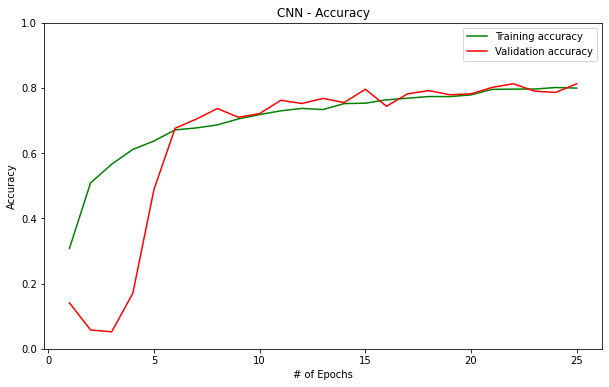

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

keys = sorted(history.history.keys())

acc_train = history.history[keys[0]]
acc_val = history.history[keys[3]]
epochs = range(1,n_epochs+1)
plt.subplots(figsize=(10,6))
plt.ylim(0,1)
plt.plot(epochs, acc_train, 'green', label='Training accuracy')
plt.plot(epochs, acc_val, 'red', label='Validation accuracy')
plt.title('CNN - Accuracy')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

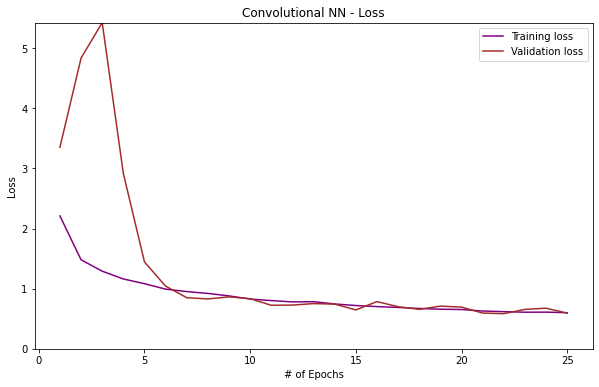

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

loss_train = history.history["loss"]
loss_val = history.history["val_loss"]
epochs = range(1,n_epochs+1)
plt.subplots(figsize=(10,6))
plt.ylim(0,np.max([loss_train,loss_val]))
plt.plot(epochs, loss_train, 'purple', label='Training loss')
plt.plot(epochs, loss_val, 'brown', label='Validation loss')
plt.title('Convolutional NN - Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

res=np.max(acc_val)
tmp = pd.DataFrame({'Learning Method':['Convolutional NN'], 'Validation Accuracy (%)': [round(100*res,2)]},index={'2'})
table= pd.concat([table, tmp])
table = table[['Learning Method', 'Validation Accuracy (%)']]
table

Learning Method  Validation Accuracy (%)
1    Machine Learning                    39.00
2  Fully Connected NN                    45.62
2    Convolutional NN                    81.27

We will now use the best model (Neural Net with Convolution layers followed by Fully Connected layers) load a test image from the disk and predict its class

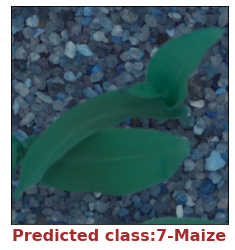

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

path = '/content/drive/MyDrive/Colab Notebooks/Assignments/CNN/Predict.png'
test_image = cv2.imread(path)
resized_image = cv2.resize(test_image,(64,64))
resized_image = resized_image.reshape(1,64,64,3)

pred_class = cnn_classifier.predict(resized_image)
pred_class_index = np.argmax(pred_class)

plt.imshow(test_image)
title = "Predicted class:"+str(pred_class_index)+"-"+plant_classes[pred_class_index]
plt.xlabel(title,fontdict = {'fontsize' : 16, 'color':'brown','fontweight':'bold'})
plt.xticks([])
plt.yticks([])
plt.show()

The trained CNN model predicts a class of **Maize - Class 7** for the test image Prediction.png

### **Part 2 - CNN Outperformance**

The Fully connected neural network performs better than the Supervised Machine Learning models because of the following reasons

1. Traditional supervised ML models such as Decision Trees, Random Forests require features to be engineered perfectly before training. This leads to considerable manual effort in finding the most optimal features of the network. However, Neural networks can learn the feature representations automatically using forward/back propogation techniques, determining regions of the image that are most useful in learning

2. Neural networks can take advantage of GPUs' parallel computational features to crunch data that is large and multi-dimensional, which is typically the case with Image classification problems 

The reasons for CNN performing better than fully connected neural networks are as follows
1. *In images, spatial correlation is local* i.e there is more correlation between feature within Region A of an image, compared to correlation between Region A and Region B of the image. \
A fully connected layer tries to correlate between different regions of the image but lack of correlation leads to *wasted connections* in the network, that not only do not contribute to learning but also lead to increased parameters and consequently, poor model performance\
CNNs extract try to correlate only those features that relatively localized. Hence they are able to learn the key characteristics of the image with much lesser fetaures and hence, provide better performance

2. We only have *limited set of training images*, in the order of 1000s or 10,000s at best. \
However, fully connected layers have trainable parameters in the order of billions. So a fully connected layer has enough capacity to largely overfit the training set i.e. it can memorize every image in the training set. This leads to poor performance on the test set. Additionally, it requires enormous computing resources esp. RAM capacity to train the network. \
CNNs use relatively fewer paramters since they extract only features that are in a small neighbourhood of a given image region. This allows CNNs to converge quicker to a minima, while reducing the probability of overfitting. Additionally, this leads to lesser memory usage and lesser training time.

3. CNNs, by using convolution and pooling layers, have the ability to be  **Translation Invariant** i.e. they can can recognize an object even when its appearance varies in some way within the image. For e.g. flipping the object, placing it in a different position within the image etc.  \
Fully connected neural networks perform poorly on shifted images because they lack translational invariance

4. CNNs can benefit from Transfer learning. Although we have not done this for Plant Species classification, they are being used in Part 4 - Flower classification problem. Since the models are pre-trained, they provide huge reduction in training time and computational resources. Also, they have been tried and tested to provide high performance. Hence, they can be reused for other Image classification problems with minimal amount of customization 

### **Part 3 - Automobile Data Set**

Source of Images
1. The Automobile image data set has been manually downloaded, labelled and organized with sample images from the Stanford Cars Dataset https://ai.stanford.edu/~jkrause/cars/car_dataset.html. We can use other public image data sets such as Imagenet, Google OpenImages etc. 

2. Alternately, data can be obtained by scraping the web for images using Python packages such as "Requests", "BeautifulSoup" and "Pillow". The scraping can be done using Bing Search API or Google Image Search APIs. The scraped images can be stored in a directory structure for further manual processing

3. In this assignment, the loaded images are stored in the directory */content/drive/MyDrive/Colab Notebooks/Assignments/CNN/cars*. There are two directories - "train" and "test". 

4. The "train" directory contains images grouped under 10 sub-directories, each corresponding to a class i.e. make of the car. The brands used are displayed in the following sections. About 15 cars per each Make have been selected to be part of the data set

5. The labelling has been done manually by visually inspecting the car make and accordingly storing it in one of the 10 training sub-directories

6. The "test" directory contains random images that have been taken from the Stanford cars image dataset.  

Load the dataset from Google Drive as a zip file. 

Note: The zip file is submitted as part of this assignment. It may be placed in an appropriate location from where it can be loaded while running this notebook

Delete the cars directory, in case it exists prior to running the notebook. Thus, we can have a clean directory to load the images into.

In [ ]:
!rm -rf /content/cars

Mount the drive containing the cars.zip dataset

In [ ]:
drive.mount('/content/drive',force_remount=True)
images_path = "/content/drive/MyDrive/Colab Notebooks/Assignments/CNN/cars.zip"

from zipfile import ZipFile
with ZipFile(images_path, 'r') as zip:
  zip.extractall()

Mounted at /content/drive


Let us list down the car make classes that are included as part of this dataset. The classes are chosen such that we could gather enough images of each class with good diversity in color, model, car type etc. This does not relate to the popularity of the car make. For e.g. Honda , one of the more popular car brands, is not included in the classes 

In [ ]:
car_classes=os.listdir('/content/cars/train/')
car_classes.sort()
car_classes

['Acura',
 'Audi',
 'BMW',
 'Buick',
 'Chevrolet',
 'Ford',
 'Hyundai',
 'Suzuki',
 'Toyota',
 'Volkswagen']

There are 10 car make classes that are provided in this data set. They were manually labelled by looking at the car image and identifying the car make

***Challenge - Labelling***\
We need to clearly define the label set and the label that will be assigned to each image. This choice depends on our Image classification problem. In this case, since the brand research company needs to classify the car make, we have assigned Car make as the label for each class. 

A different problem would have required different labels - such as "Car Make (e.g. Toyota)", "Car Model (e.g. Camry)", "Car Type (e.g. Sedan)" , "Car color (e.g. Black)". 

It can also be a combination of the any of these. For e.g. if the problem is to classify "Red Audi" (or) "White Ford Focus", then the appropriate labelling has to be made.


Let us load the image data into data objects and understand how many images are present in the training data set

Function that reads the training dataset and returns the image data and labels

In [ ]:
def readTrainData(trainDir):
    data = []
    labels = []
    disp =[]
    # loop over the input images
    dirs = os.listdir(trainDir) 
    for dir in dirs:
        absDirPath = os.path.join(os.path.sep,trainDir, dir)
        images = os.listdir(absDirPath)
        for imageFileName in images:
            # load the image, pre-process it, and store it in the data list
            imageFullPath = os.path.join(trainDir, dir, imageFileName)
            if (imageFileName=="001.jpg"):
               disp.append(imageFullPath) 
            img = load_img(imageFullPath)
            arr = img_to_array(img)  
            arr = cv2.resize(arr, (224,224)) # Resize to (224,224) as we load each image
            data.append(arr)
            label = car_classes.index(dir)
            labels.append(label)

    return data, labels, disp

Function that reads the test dataset and returns the image data and labels

In [ ]:
def readTestData(testDir):
    data = []
    # loop over the input images
    images = os.listdir(testDir)
    for imageFileName in images:
        # load the image, pre-process it, and store it in the data list
        imageFullPath = os.path.join(testDir, imageFileName)
        img = load_img(imageFullPath)
        arr = img_to_array(img)  
        arr = cv2.resize(arr, (224,224)) # Resize to (224,224) as we load each image
        data.append(arr)
    return data

In [ ]:
# X is the image array with pixel information
# Y is the encoded label (for e.g. 2="BMW") corresponding to each image
# disp is a covenience array used for visualizing the car images
X, Y, disp = readTrainData("/content/cars/train/")
X = np.array(X, dtype="float") / 255.0
Y = np.array(Y)

X_test = readTestData("/content/cars/test/")
X_test = np.array(X_test, dtype="float") / 255.0

print("There are ",len(X)," images in the training set and corresponding ",len(Y)," labels")
print("There are ",len(X_test)," images in the test set")

There are  140  images in the training set and corresponding  140  labels
There are  44  images in the test set


There are  140  images in the training set and corresponding  140  labels. 

***Challenge - Image Dataset Size***\
It is difficult to get many images to train Image classifiers. As a best practice, it is recommended to have as many images in the training set as possible as the model can learn better. As a thumb rule, we need to have at least 100 images per class.  

We need much larger set of car images, if our classification is very fine-grained, i.e. we are trying to classify based on multiple characteristics such as make, model, color, car size etc.  

In this data set, we have ~15 images per car make class. 

Now, let us visualize one image per car make class. We show the image, its label and a unique number corresponding to its label 

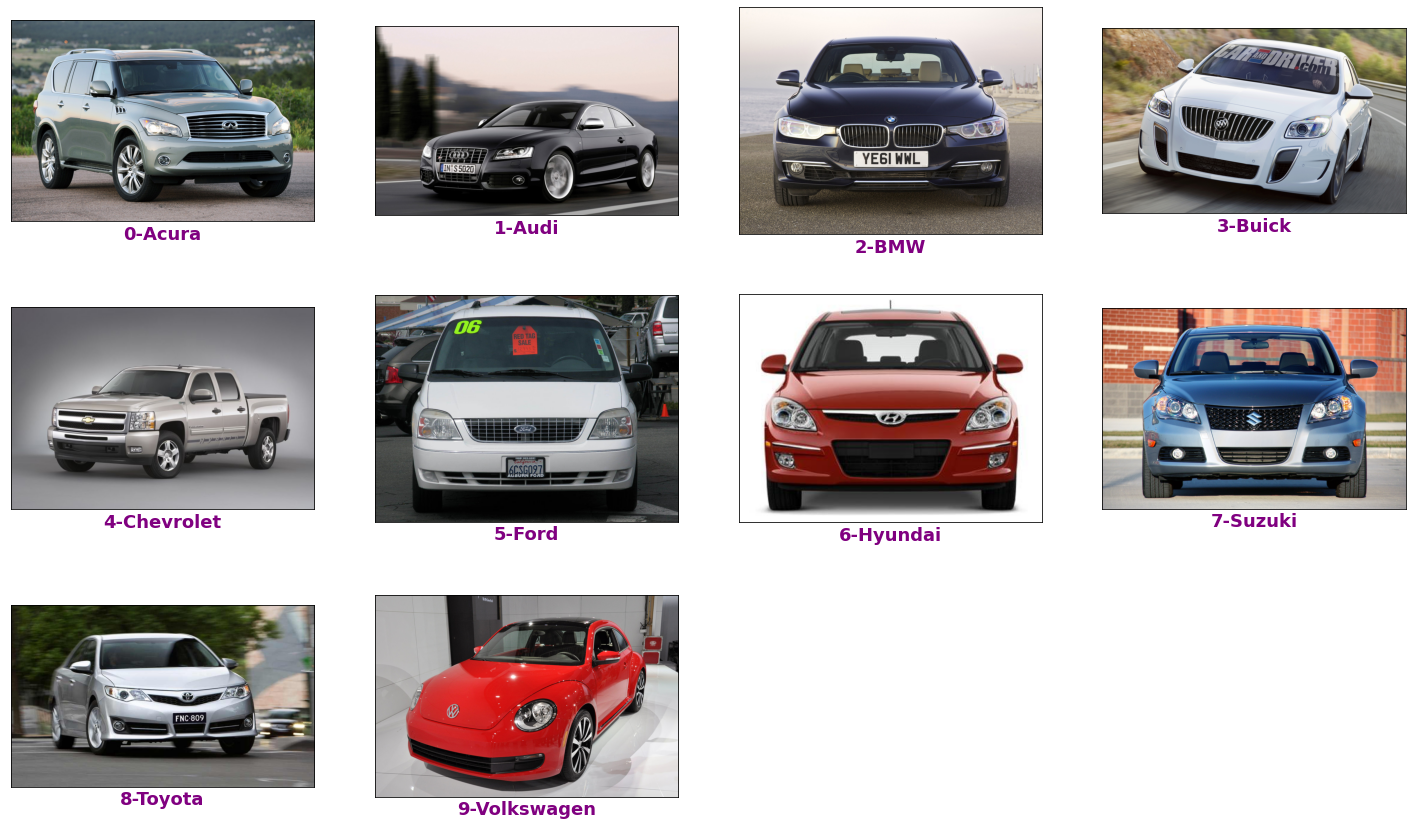

In [ ]:
fig=plt.figure(figsize=(25,15))
j=0

disp.sort()

for i in disp:
    train_image = cv2.imread(i,-1)
    train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
    
    label=i
    label=label.replace("/content/cars/train/","")
    label=label.replace("/001.jpg","")

    plt.subplot(3, 4, j+1)
    plt.imshow(train_image, cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    show = str(car_classes.index(label))+"-"+label
    plt.xlabel(show,fontdict = {'fontsize' : 18, 'color':'purple','fontweight':'bold'})

    j+=1
plt.show()

Additionally, let us visualize some random images from the training data set and their corresponding labels

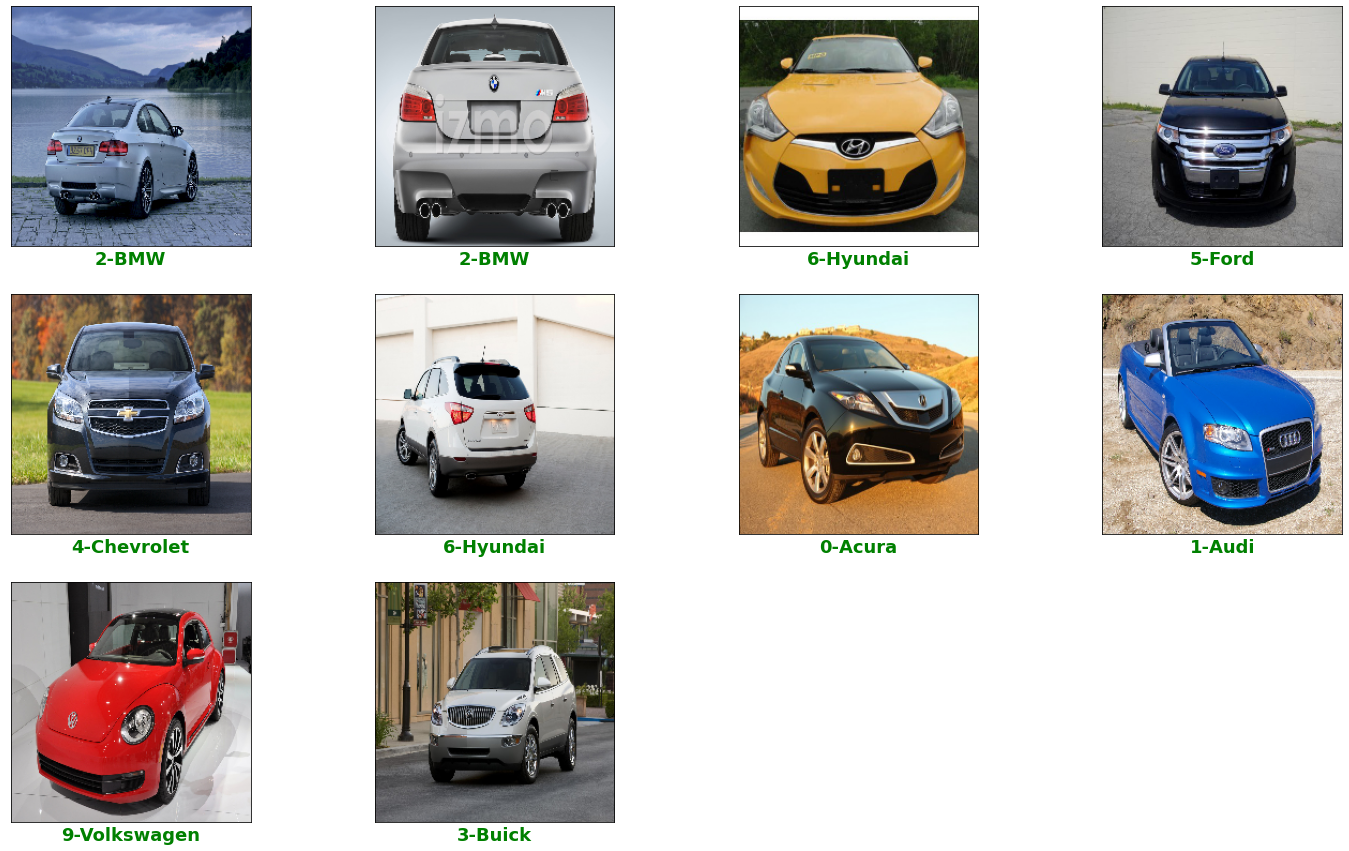

In [ ]:
fig=plt.figure(figsize=(25,15))

randarr=[]
for i in range(10):
    rand = np.random.randint(0,X.shape[0])
    plt.subplot(3, 4, i+1)
    plt.imshow(X[rand], cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(str(Y[rand])+"-"+car_classes[Y[rand]],fontdict = {'fontsize' : 18, 'color':'green','fontweight':'bold'})
plt.show()

***Challenge - Image Quality***\
a. Since this is a classification based on car make, we have to select images which have the logo prominently visible, because it is an important feature that the model has to learn. Images of cars that do not show the logo are not very useful and can be excluded from the training set.

b. One car make can have many models for e.g. the BMW has 300, 500 and 700 series of cars. These different models may look different in dimensions, design etc. We need to be able to gather as many diverse car models as possible for the network to learn them to make accurate predictions

c. The orientation of the car can be different i.e the images can be taken from top, left, right etc. from different angles. We need to be able to get different images from different perspectives and angles. For e.g. most SUVs look the same when turned 90 degrees and the logo is not visible 

d. Similarly, the images can be taken from a nearby location or they can appear further. We need a diverse pool of images shot at varying distances for the training set.

e. Many images either suffer from high brightness (which makes the logo overshadowed by light) or low brightness. Additionally, the surroundings can also be either dark or bright, making the image not suitable to be put in the training set. We need different images in different lighting conditions, to be part of the training set

f. In some cases, the major features of the car are hidden by other objects, for e.g a person standing in front of the car can hide the name or the logo. Or the image itself may be cropped leaving out the significant features of a particular make, that can be useful in training. 

g. There were many images where there was lot of noise in the image. For e.g. a Hyundai car standing in front of a dealer selling multiple car makes and models! The image has logos of multiple cars. Such images have to be manually cropped before being added to the data set, taking much effort

h. There were some images that were of poor resolution. We need to use image sharpening techiniques to highlight its important parts such as logo, name etc. before we can use them for training 

Additionally, let us visualize some random images from the test data set.

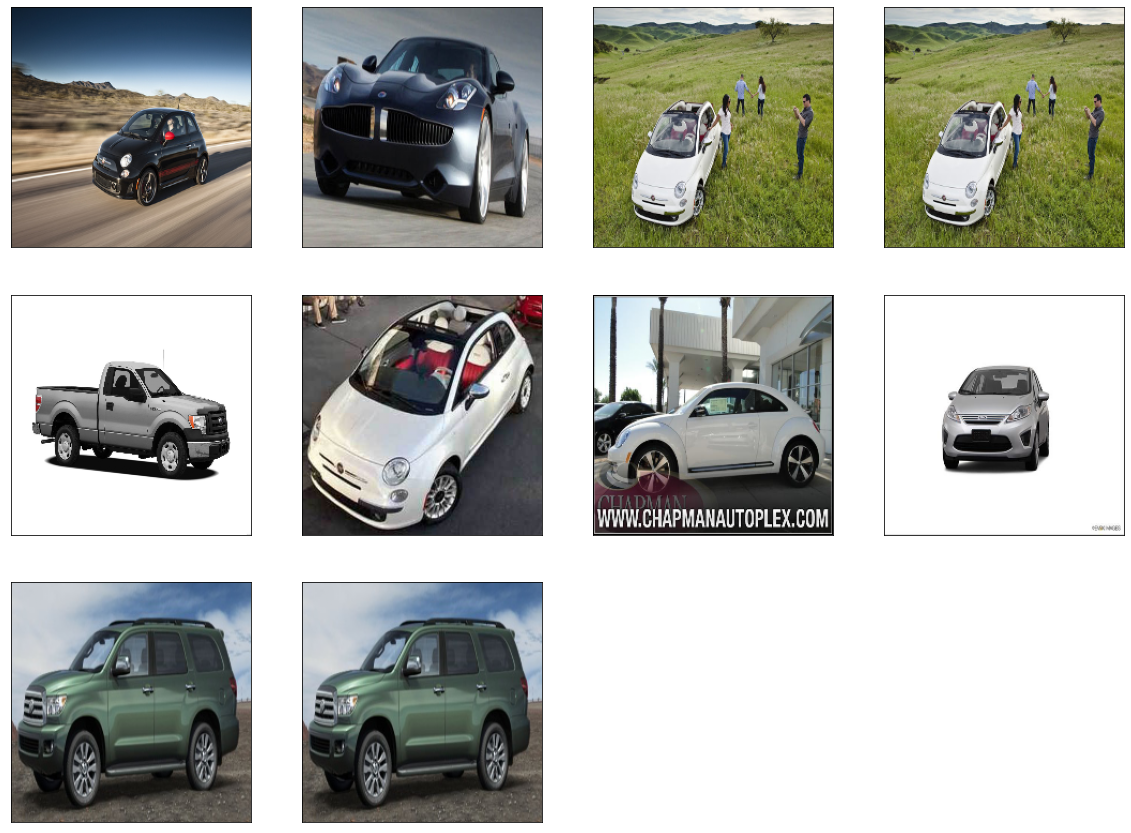

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

fig=plt.figure(figsize=(20,15))

randarr=[]
for i in range(10):
    rand = np.random.randint(0,X_test.shape[0])
    plt.subplot(3, 4, i+1)
    plt.imshow(X_test[rand], cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
plt.show()

**Summary**

1. We downloaded images of cars from the Stanford AI Dataset and organized them into train and test directories

2. Based on the make of the car, we labelled the images manually and placed them in appropriate sub directories in the training directory

3. We loaded and visualized images across all car makes as well as some random images across the training and test data sets

4. We highlighted a few challenges in creating the Cars dataset to be used for Image classification. We conclud that we need data set size, diversity of images across different features, labelling the data set are key aspects of data set composition  

### **Part 4 - Flowers ' Species Classification**

Install tflearn used for loading the data set

In [ ]:
!pip install tflearn

     |████████████████████████████████| 112kB 4.1MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp37-none-any.whl size=127301 sha256=b6a40333682199f96ecb629db1630d2acbda286e0860fc7801d6c22b9fafc868
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


Load the data into a working directory as well as into numpy arrays X,Y

In [ ]:
import tflearn.datasets.oxflower17 as oxflower17
X, Y = oxflower17.load_data(one_hot=False)

print(X.shape)
print(Y.shape)

100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!
(1360, 224, 224, 3)
(1360,)


The images are downloaded into "/content/17flowers/jpg" directory. This has 17 subdirectories, each corresponding to one class of flowers. \
There are 1360 RGB images in total, each of dimension 224 x 224 pixels across 3 channels 

We will now understand the flower classes in more detail. Based on visual inspection of sample data from each and class and based on the lass examples provided at https://www.robots.ox.ac.uk/~vgg/data/flowers/17/, the classes [0..16] are mapped to their corresponding class names, as follows\

In [ ]:
# For each flower category, its class label is the same as the index of flower_classes list. 
# Foe example, if the label is 0, the image corresponds to a Daffodil
flower_classes = ['Daffodil',
                  'Snowdrop', 
                  'Daisy', 
                  'Colts Foot',
                  'Dandelion',
                  'Cowslip', 
                  'Buttercup', 
                  'Windflower', 
                  'Pansy',
                  'Lily Valley', 
                  'Bluebell',
                  'Crocus', 
                  'Iris',
                  'Tigerlily',
                  'Tulip',
                  'Fritillary', 
                  'Sunflower'] 

Let us visualize one image from each class and their corresponding class number and name. We need this to understand which Flower class is mapped to which number between [0..16]. This information will be useful to confirm the correctness of our prediction later

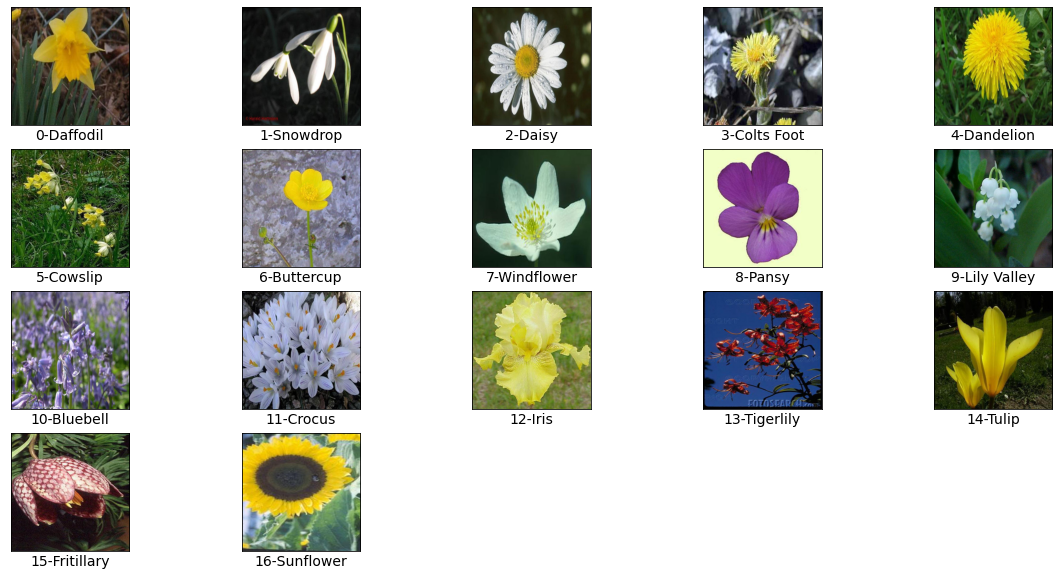

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

fig=plt.figure(figsize=(20,10))
j=0
for i in set(Y):
  result = np.where(Y == i)
  plt.subplot(4, 5, j+1)
  plt.imshow(X[result[0][0]], cmap=plt.cm.binary)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(str(i)+"-"+flower_classes[i],fontsize=14)
  j+=1
plt.show()

Additionally, Let us visualize 20 random images and their corresponding classes from the data set

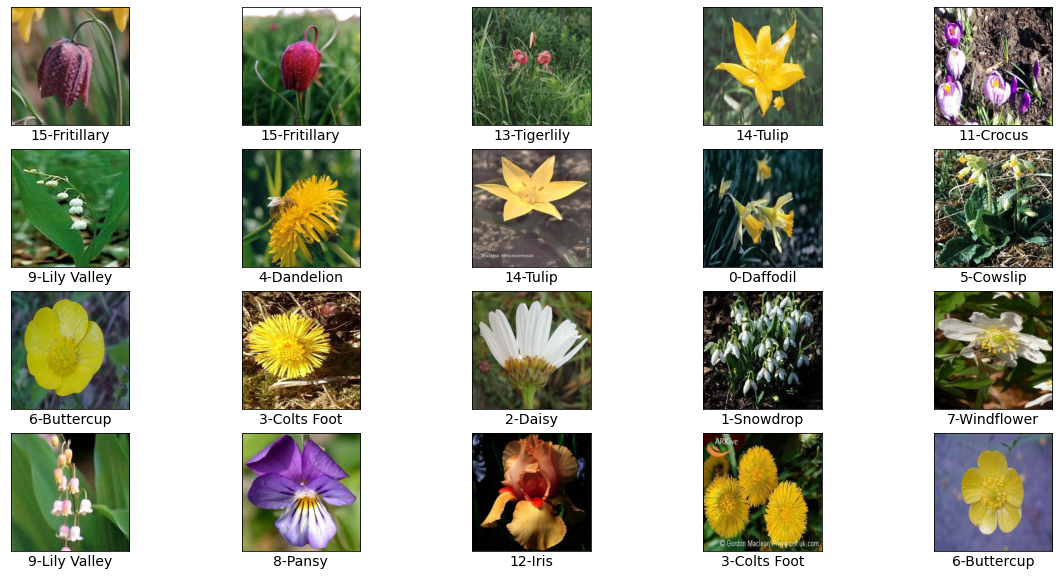

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

fig=plt.figure(figsize=(20,10))

randarr=[]
for i in range(20):
    rand = np.random.randint(0,X.shape[0])
    plt.subplot(4, 5, i+1)
    plt.imshow(X[rand], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(str(Y[rand])+"-"+flower_classes[Y[rand]],fontsize=14)
plt.show()

Let us take one sample image at random, apply different filters and display the image

1. Apply a Gaussian Blur

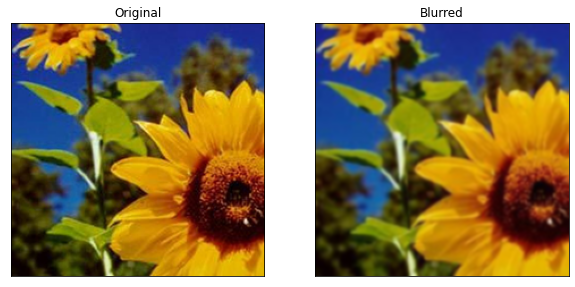

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

fig=plt.figure(figsize=(10,5))

rand = np.random.randint(0,X.shape[0])
img = X[rand]
plt.imshow(img, cmap='gray')
img_blur=cv2.GaussianBlur(img,(5,5),0)

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_blur),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

2. Convert the image color space to \
a. Grayscale\
b. HSV

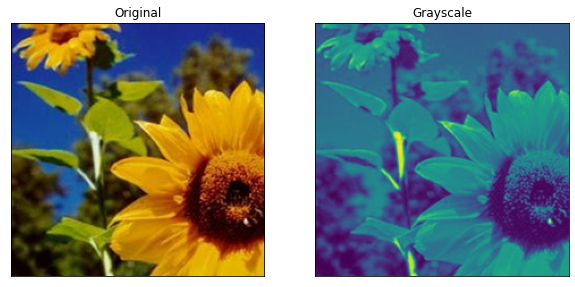

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))
fig=plt.figure(figsize=(10,5))

img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_gray),plt.title('Grayscale')
plt.xticks([]), plt.yticks([])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


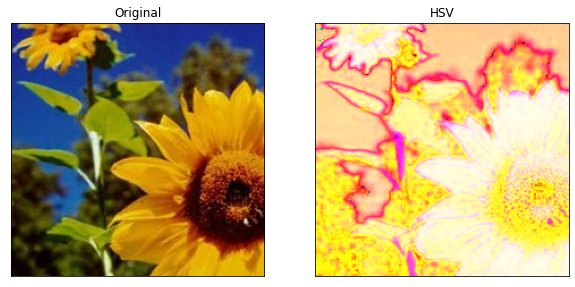

In [ ]:
fig=plt.figure(figsize=(10,5))

img_hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_hsv),plt.title('HSV')
plt.xticks([]), plt.yticks([])

plt.show()

3. Affine Transformations\
a. Shift the object location within the image\
b. Rotate the image by 270 degrees

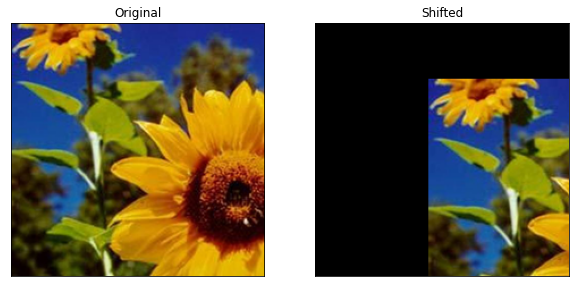

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

fig=plt.figure(figsize=(10,5))
rows,cols, channels = img.shape

M = np.float32([[1,0,100],[0,1,50]])
img_affine = cv2.warpAffine(img,M,(cols,rows))


plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_affine),plt.title('Shifted')
plt.xticks([]), plt.yticks([])

plt.show()

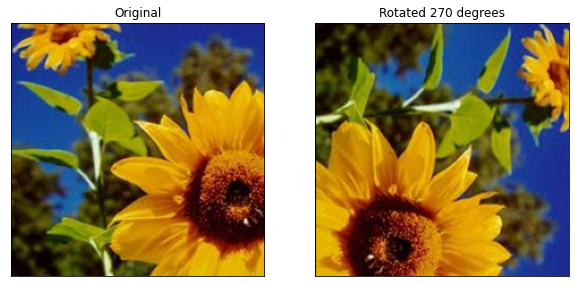

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

fig=plt.figure(figsize=(10,5))

M = cv2.getRotationMatrix2D((cols/2,rows/2),270,1)
img_rot = cv2.warpAffine(img,M,(cols,rows))

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_rot),plt.title('Rotated 270 degrees')
plt.xticks([]), plt.yticks([])

plt.show()

4. Emboss the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


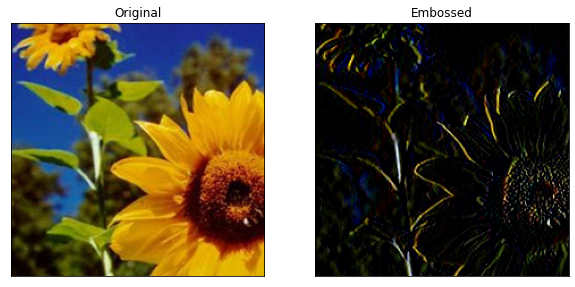

In [ ]:
fig=plt.figure(figsize=(10,5))
kernel = np.zeros( (2,2), np.float32)
kernel[0,0] = -3.0
kernel[0,1] = 3.0

img_emboss = cv2.filter2D(img, -1, kernel)

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_emboss),plt.title('Embossed')
plt.xticks([]), plt.yticks([])

plt.show()

5. Sharpen the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


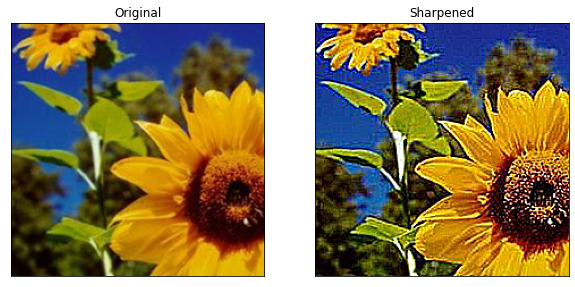

In [ ]:
fig=plt.figure(figsize=(10,5))
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

img_sharp = cv2.filter2D(img, -1, kernel)

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_sharp),plt.title('Sharpened')
plt.xticks([]), plt.yticks([])

plt.show()

5. Edge detection using a *Laplacian* kernel

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


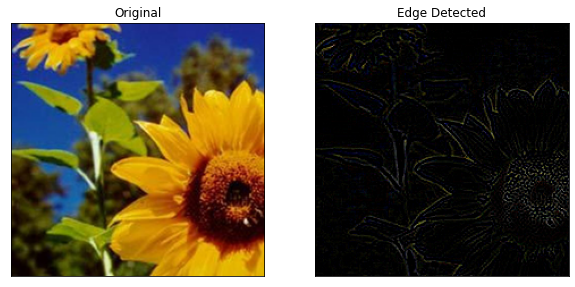

In [ ]:
fig=plt.figure(figsize=(10,5))
kernel = np.array([[0,1,0], [1,-4,1], [0,1,0]])

img_edges = cv2.filter2D(img, -1, kernel)


plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_edges),plt.title('Edge Detected')
plt.xticks([]), plt.yticks([])

plt.show()

We will now split the data into training and validation data sets

In [ ]:
X/=255

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.15, random_state=42)

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

(1156, 224, 224, 3)
(1156,)
(204, 224, 224, 3)
(204,)


Number : The training set consists of 1156 images belonging to 12 classes \
Shapes : The images are of 224 x 224 pixels in size \
Channels: All images are RGB with 3 channels

We used two supervised learning classifier algorithms \
1. RandomForest classifier \
2. DecisionTree classifier \

to train and predict the plant species classes

In [ ]:
X_train_RS = X_train.reshape(1156,224*224*3)
X_val_RS=X_val.reshape(204,224*224*3)

ml_model = RandomForestClassifier(n_estimators = 50, max_depth = 3, random_state=42)
#ml_model = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, random_state=42)


ml_model.fit(X_train_RS, y_train)
y_predict = ml_model.predict(X_val_RS)

print("Train Accuracy:",round(ml_model.score(X_train_RS, y_train)*100),"%")
res = round(ml_model.score(X_val_RS, y_val)*100)
print("Validation Accuracy :",res,"%")

Train Accuracy: 48 %
Validation Accuracy : 30 %


1. RandomForest classifier provides Train and validation accuracy in the 40% range. However, the training accuracy is close to 85% and hence the model is overfitting the data

2. DecisionTrees classifier provides train and validation accuracy in the 25 - 30% range without much overfitting

In essence, the accuracy of Supervised learning models is very slow. By tuning the hyperparameters , we see increase in training accuracy but not in validation accuracy, indicating a scenario of high variance

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

table = pd.DataFrame({'Learning Method':['Machine Learning'], 'Validation Accuracy (%)': [res]},index={'1'})
table = table[['Learning Method', 'Validation Accuracy (%)']]
table

Learning Method  Validation Accuracy (%)
1  Machine Learning                       30

As oberved in the following confusion matrix, most of the predictions are incorrect. The diagnol values representing the True positives are 0 or have very less values for almost all the classes. 

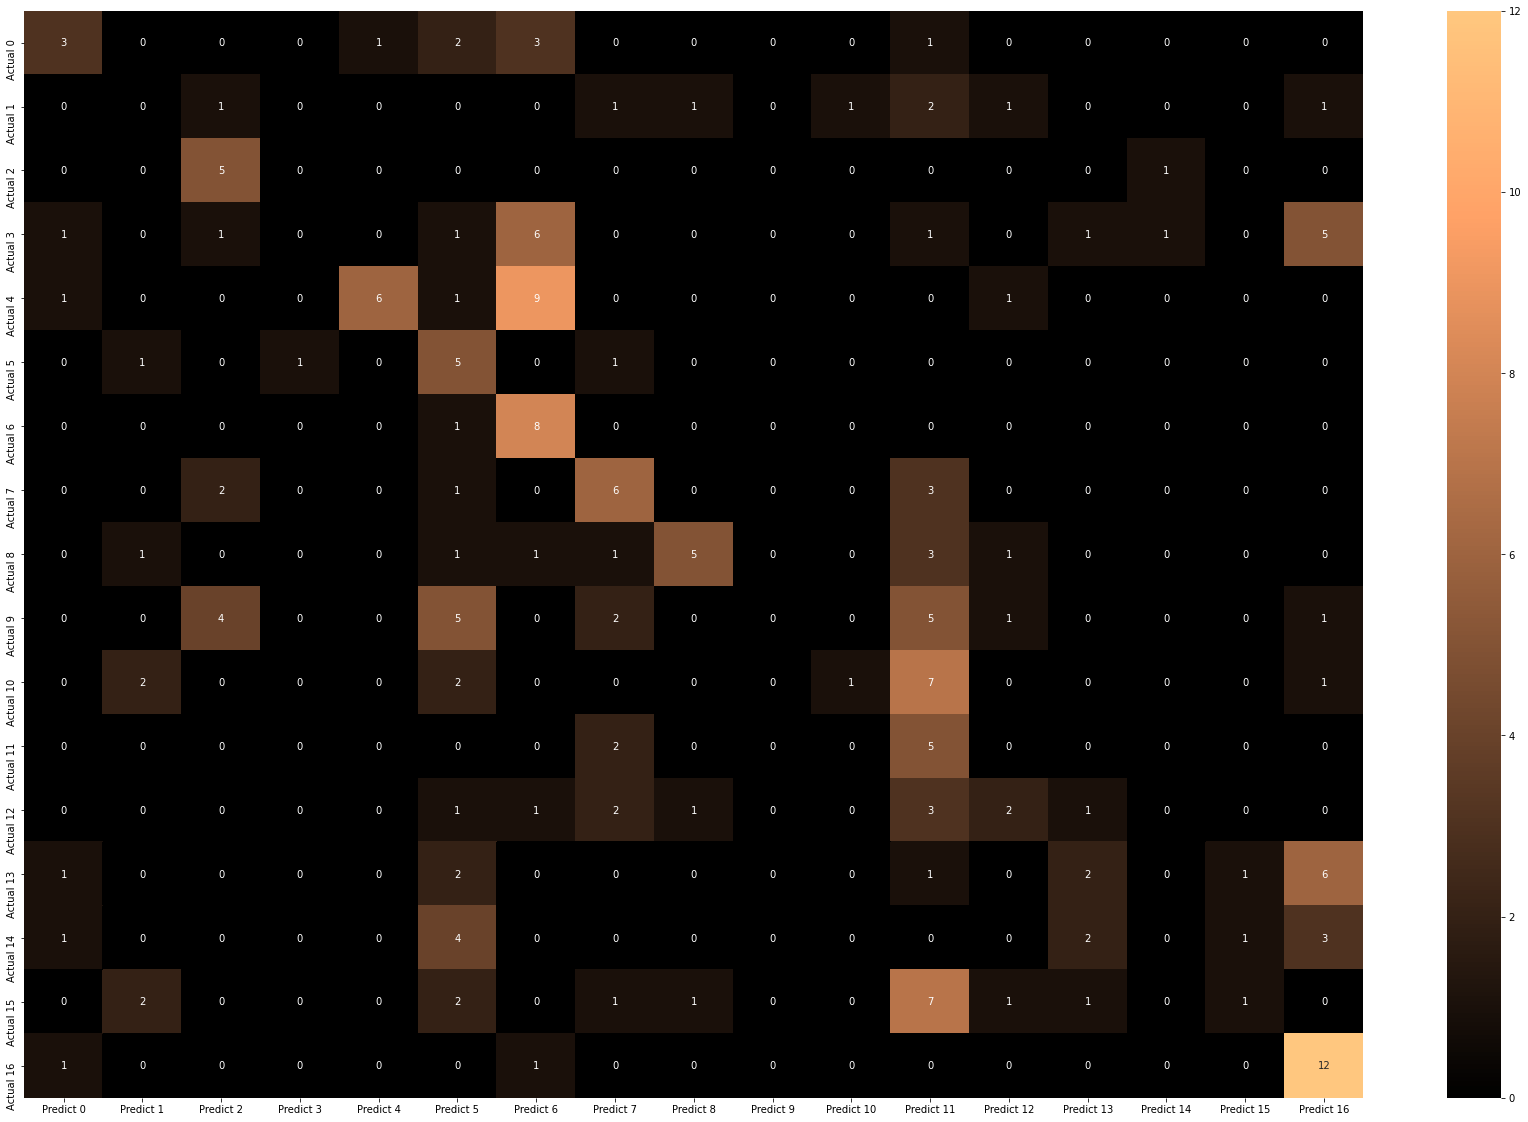

In [ ]:
cm=metrics.confusion_matrix(y_val,y_predict)

df_cm = pd.DataFrame(cm, index = ["Actual "+str(i) for i in range(0,17)],
                  columns = [i for i in ["Predict "+str(fc) for fc in range(0,17)]])
plt.figure(figsize = (30,20))
sns.heatmap(df_cm, annot=True,cmap='copper')

Next, we will try training the data using Neural networks with fully connected layers

First, we convert the image labels [0..17] to their corresponding one hot vectors, as required by the neural networks. Having done this, let us visualize the label for a random image before and after the one-hot encoding  

In [ ]:
rand = np.random.randint(0,Y.shape[0])
label = Y[rand]

y_train = to_categorical(y_train, num_classes=17)
y_test = to_categorical(y_val, num_classes=17)

print("Label of a sample image:",label)
print("It correspondng one-hot vector:", Y[rand])

Label of a sample image: 1
It correspondng one-hot vector: 1


Initialize the hyperparameters for training the fully connected neural network 

In [ ]:
batch_size=32
n_epochs=25

#opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None)
#opt = SGD(learning_rate=0.0001,momentum=0.9,nesterov=False)
opt = Adagrad(learning_rate=0.005)

dropout_ratio = 0.3
act_fn = 'relu'

Let us build a fully connected neural network with \
1. He initialization for weights
2. Batch Normalization Layers
3. Dropout layers

in order to avoid overfitting as much as possible

In [ ]:
# Initialising the Neural Networks classifier
nn_classifier = Sequential()

nn_classifier.add(Flatten())

nn_classifier.add(Dense(units = 2048,kernel_initializer='he_normal'))
nn_classifier.add(Activation(act_fn))
nn_classifier.add(BatchNormalization())
nn_classifier.add(Dropout(dropout_ratio))

nn_classifier.add(Dense(units = 1024,kernel_initializer='he_normal'))
nn_classifier.add(Activation(act_fn))
nn_classifier.add(BatchNormalization())
nn_classifier.add(Dropout(dropout_ratio))

nn_classifier.add(Dense(units = 512,kernel_initializer='he_normal'))
nn_classifier.add(Activation(act_fn))
nn_classifier.add(BatchNormalization())
nn_classifier.add(Dropout(dropout_ratio))

nn_classifier.add(Dense(units = 256,kernel_initializer='he_normal'))
nn_classifier.add(Activation(act_fn))
nn_classifier.add(BatchNormalization())
nn_classifier.add(Dropout(dropout_ratio))

nn_classifier.add(Dense(units = 128,kernel_initializer='he_normal'))
nn_classifier.add(Activation(act_fn))
nn_classifier.add(BatchNormalization())
nn_classifier.add(Dropout(dropout_ratio))

nn_classifier.add(Dense(units = 64,kernel_initializer='he_normal'))
nn_classifier.add(Activation(act_fn))
nn_classifier.add(BatchNormalization())

# The final output layer with 10 neurons to predict the categorical classifcation
nn_classifier.add(Dense(units = 17, activation = 'softmax'))

We will use the images stored in the file system to train the data set. We take the following measures to maximize the performance of the network as much as possible \
1. Split the entire data set of 1160 images into training and validation sets (15%)
2. Perform data augmentation by randomly flipping, shearing, zooming the image set and random shuffling of the data set 
3. Register callbacks for Learning Rate Annealing, Early stopping and Best Model saving for the FCNN model  

In [ ]:
train_datagen = ImageDataGenerator(shear_range = 0.2,
                                  zoom_range = 0.2,
                                  width_shift_range=0.2,
                                  rotation_range=10, 
                                  height_shift_range=0.2,
                                  horizontal_flip = True,
                                  vertical_flip=True,
                                  validation_split=0.15)

training_set = train_datagen.flow_from_directory('/content/17flowers/jpg',
                                                target_size = (224, 224),
                                                batch_size = batch_size,
                                                class_mode = 'categorical',
                                                subset='training',
                                                shuffle=True)

val_set = train_datagen.flow_from_directory('/content/17flowers/jpg',
                                          target_size = (224, 224),
                                          batch_size = batch_size,
                                          class_mode = 'categorical',
                                          subset='validation',
                                          shuffle=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                          patience=5,
                                          verbose=1,
                                          factor=0.5,
                                          min_lr=0.00001)

stop_early = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

save_bestmodel = ModelCheckpoint('nn_flower_best_model.h5'
                              ,monitor='val_acc'
                              ,save_best_only=True
                              ,save_weights_only=True)

Found 1156 images belonging to 17 classes.
Found 204 images belonging to 17 classes.


In [ ]:
nn_classifier.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = nn_classifier.fit_generator(training_set,
                                      epochs = n_epochs,
                                      validation_data = val_set,
                                      callbacks=[reduce_lr, 
                                      #stop_early,
                                      save_bestmodel])

Epoch 1/25
37/37 [==============================] - 37s 720ms/step - batch: 18.0000 - size: 31.2432 - loss: 3.3488 - acc: 0.0517 - val_loss: 29.5489 - val_acc: 0.0588
Epoch 2/25
37/37 [==============================] - 22s 605ms/step - batch: 18.0000 - size: 31.2432 - loss: 3.1356 - acc: 0.0952 - val_loss: 99.7730 - val_acc: 0.0588
Epoch 3/25
37/37 [==============================] - 27s 743ms/step - batch: 18.0000 - size: 31.2432 - loss: 3.0990 - acc: 0.0978 - val_loss: 5.7936 - val_acc: 0.1078
Epoch 4/25
37/37 [==============================] - 22s 610ms/step - batch: 18.0000 - size: 31.2432 - loss: 2.9402 - acc: 0.1194 - val_loss: 5.2477 - val_acc: 0.1078
Epoch 5/25
37/37 [==============================] - 22s 614ms/step - batch: 18.0000 - size: 31.2432 - loss: 2.9258 - acc: 0.1237 - val_loss: 140.6549 - val_acc: 0.0588
Epoch 6/25
37/37 [==============================] - 27s 745ms/step - batch: 18.0000 - size: 31.2432 - loss: 2.9088 - acc: 0.1185 - val_loss: 2.8055 - val_acc: 0.1765


Let us plot the Accuracy and Loss trends for this model

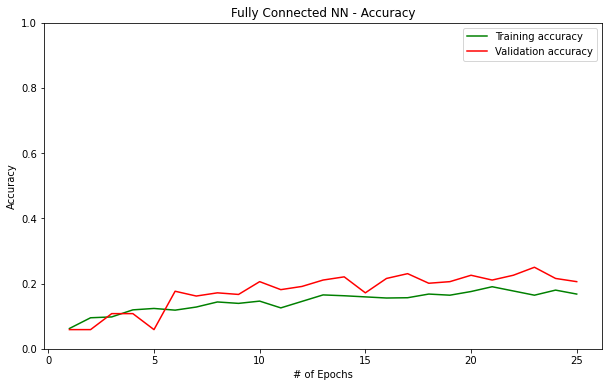

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

keys = sorted(history.history.keys())

acc_train = history.history["acc"]
acc_val = history.history["val_acc"]
epochs = range(1,n_epochs+1)
plt.subplots(figsize=(10,6))
plt.ylim(0,1)
plt.plot(epochs, acc_train, 'green', label='Training accuracy')
plt.plot(epochs, acc_val, 'red', label='Validation accuracy')
plt.title('Fully Connected NN - Accuracy')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

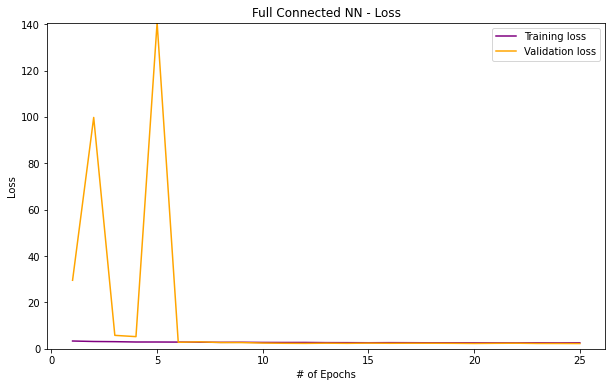

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

loss_train = history.history["loss"]
loss_val = history.history["val_loss"]
epochs = range(1,n_epochs+1)
plt.subplots(figsize=(10,6))
plt.ylim(0,np.max([loss_train,loss_val]))
plt.plot(epochs, loss_train, 'purple', label='Training loss')
plt.plot(epochs, loss_val, 'orange', label='Validation loss')
plt.title('Full Connected NN - Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

res=np.max(acc_val)
tmp = pd.DataFrame({'Learning Method':['Fully Connected NN'], 'Validation Accuracy (%)': [round(100*res,2)]},index={'2'})
table= pd.concat([table, tmp])
table = table[['Learning Method', 'Validation Accuracy (%)']]
table

Learning Method  Validation Accuracy (%)
1    Machine Learning                     30.0
2  Fully Connected NN                     25.0

Fully connected neural network without any convolutional layers provides a very low validation accuracy of ~25-30% for both training and validation data sets. This seems to be even worse than the supervised machine learning models.There is no overfitting seen at this level of accuracy but the model suffers from a very heavy bias

As the next step, we will build a network from scratch, based on  Convolutional Layers + Fully Connected Layers to train the data set

Initialize the hyperparameters for the Convolutional NN

In [ ]:
#opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None)
#opt = SGD(learning_rate=0.0001,momentum=0.99,nesterov=False)
opt = Adagrad(learning_rate=0.005)

dropout_ratio = 0.4
n_epochs = 30

In [ ]:
# Initialising the CNN classifier
cnn_classifier = Sequential()

# Add a Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
cnn_classifier.add(Conv2D(32, (3, 3), input_shape = (224, 224, 3), padding='same'))
cnn_classifier.add(BatchNormalization())
cnn_classifier.add(Activation(act_fn))
# cnn_classifier.add(Conv2D(64, (3, 3), padding='valid'))
# cnn_classifier.add(Activation(act_fn))
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))
#cnn_classifier.add(Dropout(dropout_ratio))

# cnn_classifier.add(Conv2D(128, (3, 3), padding='valid'))
# cnn_classifier.add(BatchNormalization())
# cnn_classifier.add(Activation(act_fn))
# cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

cnn_classifier.add(Conv2D(16, (3, 3), padding='valid'))
cnn_classifier.add(BatchNormalization())
cnn_classifier.add(Activation(act_fn))
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))
cnn_classifier.add(Dropout(dropout_ratio))

cnn_classifier.add(Flatten())

cnn_classifier.add(Dense(units = 64))
cnn_classifier.add(BatchNormalization())
cnn_classifier.add(Activation(act_fn))

# The final output layer with 10 neurons to predict the categorical classifcation
cnn_classifier.add(Dense(units = 17, activation = 'softmax'))

Compile and fit the Convolutional NN

In [ ]:
save_bestmodel = ModelCheckpoint('cnn_flower_best_model.h5'
                                ,monitor='val_acc'
                                ,save_best_only=True
                                ,save_weights_only=True)

cnn_classifier.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = cnn_classifier.fit_generator(training_set,
                                       epochs = n_epochs,
                                       validation_data = val_set,
                                       callbacks=[reduce_lr,
                                       #stop_early, 
                                       save_bestmodel])

Epoch 1/30
37/37 [==============================] - 26s 658ms/step - batch: 18.0000 - size: 31.2432 - loss: 2.4037 - acc: 0.2413 - val_loss: 7.9565 - val_acc: 0.1863
Epoch 2/30
37/37 [==============================] - 22s 598ms/step - batch: 18.0000 - size: 31.2432 - loss: 2.0062 - acc: 0.3737 - val_loss: 3.7820 - val_acc: 0.2206
Epoch 3/30
37/37 [==============================] - 22s 598ms/step - batch: 18.0000 - size: 31.2432 - loss: 1.8478 - acc: 0.4291 - val_loss: 2.6594 - val_acc: 0.2843
Epoch 4/30
37/37 [==============================] - 22s 598ms/step - batch: 18.0000 - size: 31.2432 - loss: 1.7714 - acc: 0.4792 - val_loss: 1.9248 - val_acc: 0.4069
Epoch 5/30
37/37 [==============================] - 22s 600ms/step - batch: 18.0000 - size: 31.2432 - loss: 1.6781 - acc: 0.4974 - val_loss: 1.7985 - val_acc: 0.4363
Epoch 6/30
37/37 [==============================] - 22s 599ms/step - batch: 18.0000 - size: 31.2432 - loss: 1.6441 - acc: 0.4983 - val_loss: 1.9044 - val_acc: 0.4069
Epoc

Let us plot the model accuracy and loss

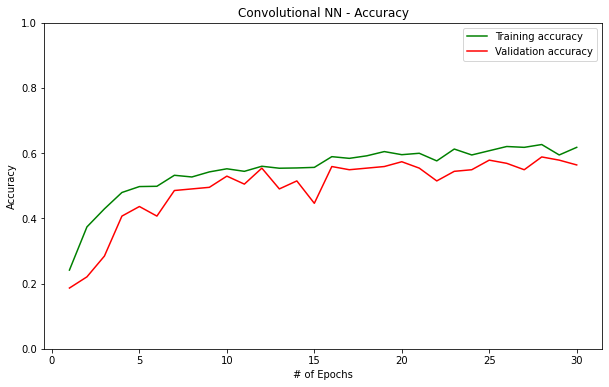

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))
keys = sorted(history.history.keys())

acc_train = history.history["acc"]
acc_val = history.history["val_acc"]
epochs = range(1,n_epochs+1)
plt.subplots(figsize=(10,6))
plt.ylim(0,1)
plt.plot(epochs, acc_train, 'green', label='Training accuracy')
plt.plot(epochs, acc_val, 'red', label='Validation accuracy')
plt.title('Convolutional NN - Accuracy')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

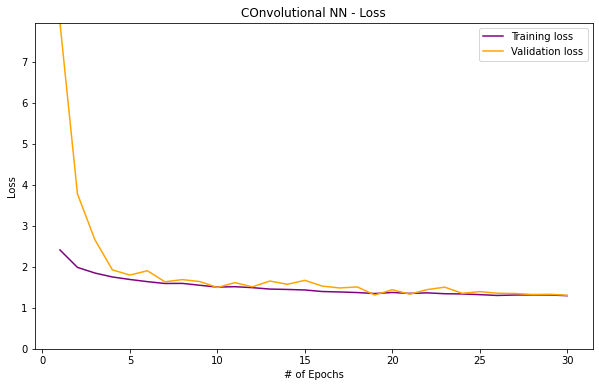

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

loss_train = history.history["loss"]
loss_val = history.history["val_loss"]
epochs = range(1,n_epochs+1)
plt.subplots(figsize=(10,6))
plt.ylim(0,np.max([loss_train,loss_val]))
plt.plot(epochs, loss_train, 'purple', label='Training loss')
plt.plot(epochs, loss_val, 'orange', label='Validation loss')
plt.title('COnvolutional NN - Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

res=np.max(acc_val)
tmp = pd.DataFrame({'Learning Method':['Convolutional NN'], 'Validation Accuracy (%)': [round(100*res,2)]},index={'3'})
table= pd.concat([table, tmp])
table = table[['Learning Method', 'Validation Accuracy (%)']]
table

Learning Method  Validation Accuracy (%)
1    Machine Learning                    30.00
2  Fully Connected NN                    25.00
3    Convolutional NN                    58.82

Once again, it is observed that Convolutional NN provides a significant uptick in model performance compared to Fully Connected NN. This model is able to consistent reach accuracy values **around 60%** without overfitting.

However, it looks there is an opportunity to squeeze out better performance with the given data set using other techniques such as Transfer learning

In this part, we will train the image data set using the following pre-trained models {ResNet50, VGG Network 19, Inception V3, MobileNet V2}. The models come with pre-trained weights which we will just reuse for the Convolutional Layers. We will excluded the Fully Connected layers from the pre-trained models and customize them for training the Flower Classification data set  



Initialize the hyperparameters

In [ ]:
n_epochs=50
batch_size=128

#opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None)
#opt = SGD(learning_rate=0.0001,momentum=0.9,nesterov=False)
opt = Adagrad(learning_rate=0.005)
#opt = Adadelta(learning_rate=0.001)

dropout_ratio = 0.1

Load the the following pre-trained models  
1. ResNet50
2. VGG17
3.InceptionV3
4. MobileNetV2

Customize the fully connected layers by adding a 32 neuron layer with ReLU activation and final output layer with 17 neurons with softmax activation

Note: In order to maximize the model performance, I have tuned the n_epochs to 50. Since the CNN layer weights are pre-trained, this does not take much time to train (~20s/epoch i.e. less than 20 mins) hand hence, we let it run for 50 epochs  

In [ ]:
# base_model = ResNet50(input_shape=(224, 224, 3),input_tensor=None,
#                       include_top=False, weights='imagenet', pooling='avg')

base_model = VGG19(include_top=False,weights="imagenet",
                   input_tensor=None, 
                   input_shape=(224, 224, 3),
                   pooling='avg')

# base_model = MobileNetV2(include_top=False, weights="imagenet",
#                          input_tensor=None, input_shape=(224,224,3),
#                          pooling='avg')


# base_model = InceptionV3(include_top=False, weights="imagenet",
#                          input_tensor=None, input_shape=(224,224,3),
#                          pooling='avg')

# Only train Dense layers
for layer in base_model.layers:
    layer.trainable = False

tl_cnn_classifier = Sequential([
                                base_model,
                                Flatten(),
                                Dense(32, activation='relu'),
                                Dense(17, activation='softmax'),
                                ])

save_bestmodel = ModelCheckpoint('tl_cnn_flower_best_model.h5'
                                  ,monitor='val_acc'
                                  ,save_best_only=True
                                  ,save_weights_only=True)

tl_cnn_classifier.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])


history = tl_cnn_classifier.fit_generator(training_set,
                                          epochs = n_epochs,
                                          validation_data = val_set,
                                          callbacks=[save_bestmodel])

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/50
37/37 [==============================] - 38s 749ms/step - batch: 18.0000 - size: 31.2432 - loss: 3.4873 - acc: 0.1159 - val_loss: 2.5016 - val_acc: 0.1961
Epoch 2/50
37/37 [==============================] - 23s 632ms/step - batch: 18.0000 - size: 31.2432 - loss: 2.4635 - acc: 0.2301 - val_loss: 2.2122 - val_acc: 0.2647
Epoch 3/50
37/37 [==============================] - 25s 675ms/step - batch: 18.0000 - size: 31.2432 - loss: 2.2573 - acc: 0.2889 - val_loss: 2.1477 - val_acc: 0.3431
Epoch 4/50
37/37 [==============================] - 25s 675ms/step - batch: 18.0000 - size: 31.2432 - loss: 2.1012 - acc: 0.3469 - val_loss: 1.9420 - val_acc: 0.3627
Epoch 5/50
37/37 [==============================] - 24s 673ms/step - batch: 18.0000 - size: 31.2432 - loss: 1.8853 - acc: 0.3971 - val_loss: 1.8278 - val_acc: 0.4167
Epoch 6/50
37/37 [==============================] - 24s 673ms/step - batch: 18.0000 - size: 31.2432 - los

Let us plot the model accuracy and loss

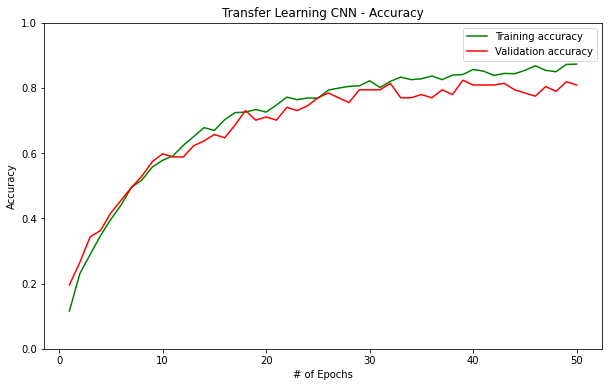

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

keys = sorted(history.history.keys())

acc_train = history.history["acc"]
acc_val = history.history["val_acc"]
epochs = range(1,n_epochs+1)
plt.subplots(figsize=(10,6))
plt.ylim(0,1)
plt.plot(epochs, acc_train, 'green', label='Training accuracy')
plt.plot(epochs, acc_val, 'red', label='Validation accuracy')
plt.title('Transfer Learning CNN - Accuracy')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

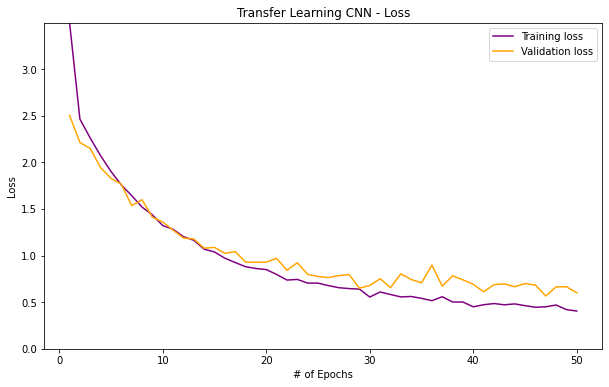

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))


loss_train = history.history["loss"]
loss_val = history.history["val_loss"]
epochs = range(1,n_epochs+1)
plt.subplots(figsize=(10,6))
plt.ylim(0,np.max([loss_train,loss_val]))
plt.plot(epochs, loss_train, 'purple', label='Training loss')
plt.plot(epochs, loss_val, 'orange', label='Validation loss')
plt.title('Transfer Learning CNN - Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

res=np.max(acc_val)
tmp = pd.DataFrame({'Learning Method':['Transfer Learning CNN'], 'Validation Accuracy (%)': [round(100*res,2)]},index={'4'})
table= pd.concat([table, tmp])
table = table[['Learning Method', 'Validation Accuracy (%)']]
table

Learning Method  Validation Accuracy (%)
1       Machine Learning                    30.00
2     Fully Connected NN                    25.00
3       Convolutional NN                    58.82
4  Transfer Learning CNN                    82.35

The following observations are made

1. Using Pre-trained models with customized Fully connected layers provides the best performance for the data set

2. Of all the 4 pre-trained models taken up for experimentation, on a consistent basis

  a. **VGG 17 Net** provides the best performance with a validation accuracy of  ~85% without any overfitting

  b. ResNet50 gives a validation accuracy of ~65%. However, there is some overfitting seen as the training accuracy is ~90%

  c. Google's InceptionV3 provides a validation accuracy of only ~10% with significant overfitting. 

  d. MobileNet provides a validation accuracy of only ~10% with significant overfitting. 

The best model comes out as the one with Base model as a pre-trained VGGNet17 with Convolution Layers and further customized to this prediction problem using Fully Connected layers. We will save the weights of this model so that they can be loaded from any other program

In [ ]:
tl_cnn_classifier.save_weights("flower_weights")

***Flower class prediction***

We will now use the best model  (Model with pre-trained VGGNet17 CNN Layers with customized Fully Connected layers added to it) load a test image from the disk and predict its class. 

We provide two ways to predict the flower class. The user is free to adopt one as per convenience 

1. Upload the image in this Colab notebook. The predicted class will be displayed in the subsequent steps of this notebook

2. Use a custom-built GUI to load any image from the disk. To do this, the following steps have to be performed\
  a. The GUI has to be invoked using the Jupyter notebook named "Flower Class Prediction.ipynb"

  b. The model weights file that is saved using name "flower_weights" has to be used in the notebook mentioned above

In [ ]:
test_image_file = files.upload()
filename = next(iter(test_image_file))
print ("Will predict class for image named",filename)

Saving Prediction - Flower.jpg to Prediction - Flower.jpg
Will predict class for image named Prediction - Flower.jpg


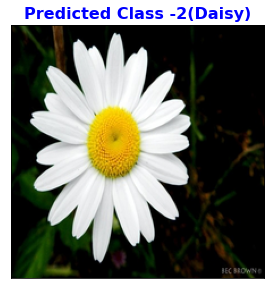

In [ ]:
path = '/content/'+filename

img = image.load_img(path, target_size=(224,224))
test_image = image.img_to_array(img)
test_image = np.expand_dims(test_image,axis=0)
result = tl_cnn_classifier.predict(test_image)

flower_class = np.argmax(result,axis=1)[0]

display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

fig=plt.figure(figsize=(10,5))

title = 'Predicted Class -'+str(flower_class)+'('+flower_classes[flower_class]+')'

plt.subplot(121),plt.imshow(img),plt.title(title,fontdict = {'fontsize' : 16, 'color':'blue','fontweight':'bold'})
plt.xticks([]), plt.yticks([])

plt.show()

## **Part 5 - Classifier Maintenance Strategy**

After the Classifier model is built and we are satisfied with its output, we need to productionize it - this broadly involves the following
1. Deploy the model into production
2. Continuously monitor and improve performance

###Model Deployment & Management

This is the process of making the model available in a production environment, which is open to real-life users. This is a critical complex activity involving multiple stakeholders such as Business people, Data Scientists, Architects and Data Engineers. to ensure that a stable and well-performing model is in production.

The process of saving a trained model with weights is called Model pickling or Serialization. The inverse operation is called Model loading or Deserialization. This is used to save and load the models across different machines

####Deployment Considerations
1. ***Model portability*** - We should be able to run the model in multiple environments, without making much changes. This is best done through Model containerization - wherein the model and all its dependencies are packaged in a standardized manner into a container such as Docker. The container can be deployed (on/premise or cloud), in different environments (TEST/PRE-PROD/PROD etc.)  and across different operating systems. Additionally, it is important that model metrics such as accuracy, loss have to be consistent and replicable across different operating environments 

2. ***Availability*** : We need to be able to update the productionalized model without impacting availabilty of the end-user solution. For e.g. this could  happen when have upgraded model performance and want to go for a hot deployment. Lack of availability could have undesirable business impact

3. ***Versioning***:Model version co-existence in production. We might have two different versions of the same model in order to cater to different user segments or corresponding to two different releases 

4. ***Scalability***: Scale the model as the user and transaction volumes increase without impacting other SLAs such as latency and transaction throughput 

5. ***Fault Tolerance and Recovery***: Rollback to an earlier version of model , because the production model has a bug or reports poorer performance than an earlier version

The following aspects of Model productionization has to be considered

6. Data Considerations
#### Data Management

a. ***Infrastructure - Data Storage*** : We need to store the data closer to the Model Execution engine in production. This could be it on Cloud or on-premise

b. ***Infrastructure - Data Processing*** : We need to estimate the data volumes and accordingly determine compute capacity such as # of virtual machines, GPU specification and size.

c. ***Data Integration Pattern*** : Requests to the model can be sent either in real-time manner or in a batch mode. We need to plan for both these patterns and design the solution accordingly. Similarly, plan for test data ingestion before prediction

Batch jobs can be scheduled to load the model, load the data, score the model and store the results. These jobs can be built using cron jobs or other task scheduling tools.
Real-time requests can be served by exposing the model as a REST API using Python Flask and Requests modules

#### Frameworks & Tools

The platform and tools used for deployment must be chosen considering the business requirements. This includes avoiding vendor lock-in, OS support, open-sourced nature of the tool, deployability on cloud environments, multi-channel (mobile/web) support, licensing cost etc. 

This is best done in an automated manner using DevOps and CI/CD approach. Some of the common model deployment tools used in the industry are 

1. Docker – Allows the model along with its dependencies to be containerized , enabling it to be run consistently across different environments

2. Kubernetes - Container Orchestrator - This is used to 
                a. Auto-scale the nodes where Models are running
                b. Load balance the requests between multiple nodes
                c. Provide fault tolerance

3. Model deployment tool kits available in AWS Sagemaker and Azure ML

4. Python Flask, Tensor Serving - Used to expose the model as a REST API running on a given server/port

####Continuous Improvement
1. ***Model Visualization*** : We need to be able to view model execution and  performance metrics using visual dashboards. This allows us to obtain valuable feedback from production such as 

a. The model should perform as expected in terms of functionality i.e. accuracy, loss etc. are within expected threshold values. Over time , model performance may depreciate due to the following factors

i. High bias: If the images are trained using a sparse training set, it may suffer from high bias and may not be to able to make the right predictions with real-life images. 

ii. Underperformance due to change in business context : Models are trained with a certain business context. If that changes with time, the model has to be revisited and retrained. For e.g. Fraud detection solutions - as we encounter newer ways in which Fraud is committed, we will have to also refine the model so that it is in sync with the business need

In this context, we can use ***Incremental Learning*** for certain algorithms, which allows the model to learn continuously and evolve based on real-life data inputs while retaining previously learnt knowledge. Models in production can either be retained or updated based on model accuracy deterioration (meaning data has noise) or improvement respectively

b. The model is able to adhere to performance SLAs such as latency time, availability, scalability and auto-recovery in case of failures
Quick identification of any potential issues helps in taking quick remedial measures to reduce business impact. It also helps in refining the overall deployment process

2. ***Automated Model deployments*** : As product features are rolled out in an Agile manner, it is imperative that we are able to quickly deploy/redeploy models without impacting the existing model usage by end customers. 

It is advisable to use DevOps CI/CD pipelines to automate the end to end development to deployment lifecycle

3. Define the key metrics and KPIs that need to be tracked on an ongoing basis. For e.g. Model Accuracy, Model Loss. Business KPIs should also be monitored to see if the model is really helping in achieving the intended business objective